In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [2]:
df = pd.read_csv("cirrhosis.csv")

In [3]:
df = df.dropna(subset='Drug')
df = df.drop('ID', axis=1)
delete = df[ (df['Status'] =='CL')].index
df = df.drop(delete, inplace=False)
df

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1153,C,D-penicillamine,22347,F,N,Y,N,N,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0
308,994,C,Placebo,21294,F,N,N,N,N,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0
309,939,C,D-penicillamine,22767,F,N,N,N,N,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0
310,839,C,D-penicillamine,13879,F,N,N,N,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0


In [4]:
count_cl = (df['Status'] == 'CL').sum()
count_c = (df['Status'] == 'C').sum()
count_d = (df['Status'] == 'D').sum()

print(f"Количество 'CL': {count_cl}")
print(f"Количество 'C': {count_c}")
print(f"Количество 'D': {count_d}")

Количество 'CL': 0
Количество 'C': 168
Количество 'D': 125


In [5]:
df.Age = (df.Age/365.25).astype('int64')

In [6]:
pd.DataFrame(df.isnull().sum(), 
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/df.shape[0]*100).astype(float).round(1).T

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
missing_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,2.0,0.0,0.0,29.0,4.0,0.0,0.0
missing_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2,0.0,0.7,0.0,0.0,9.9,1.4,0.0,0.0


In [7]:
df.groupby('Status')['Cholesterol'].mean()
df.groupby('Status')['Copper'].mean()
df.groupby('Status')['Tryglicerides'].mean()
df.groupby('Status')['Platelets'].mean()

Status
C    272.563636
D    242.137097
Name: Platelets, dtype: float64

In [8]:
#  поменять потом на более красивое решение с DRY
df['Cholesterol'] = df['Cholesterol'].fillna(
    df['Status'].apply(lambda x: 415.75 if x == 'D' else 326.53)
)
df['Copper'] = df['Copper'].fillna(
    df['Status'].apply(lambda x: 135.41 if x == 'D' else 66.61)
)
df['Tryglicerides'] = df['Tryglicerides'].fillna(
    df['Status'].apply(lambda x: 140.48 if x == 'D' else 111.78)
)
df['Platelets'] = df['Platelets'].fillna(
    df['Status'].apply(lambda x: 242.13 if x == 'D' else 272.56)
)

In [9]:
pd.DataFrame(df.isnull().sum(), 
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/df.shape[0]*100).astype(float).round(1).T

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
missing_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
missing_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
enc = OneHotEncoder(sparse_output=False)
encoded_features = enc.fit_transform(df[['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']])
enc_df = pd.DataFrame(encoded_features, columns=enc.get_feature_names_out())
enc_df

,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
289,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
290,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
291,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
df = df.reset_index(drop=True)
enc_df = enc_df.reset_index(drop=True)

In [12]:
df_ohe = df.drop(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'], axis=1)\
              .join(enc_df)
df_ohe

,N_Days,Status,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0
0,400,D,58,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4500,C,56,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1012,D,70,1.4,176.0,3.48,210.0,516.0,96.10,55.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1925,D,54,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2503,D,66,0.8,248.0,3.98,50.0,944.0,93.00,63.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1153,C,61,0.4,246.0,3.58,24.0,797.0,91.00,113.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
289,994,C,58,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
290,939,C,62,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
291,839,C,37,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
def quality_report(actual, prediction):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(actual, prediction),
        precision_score(actual, prediction),
        recall_score(actual, prediction),
        f1_score(actual, prediction)
    ))

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_ohe['Status'] = le.fit_transform(df['Status'])

In [15]:
X = df_ohe.drop(['Status'], axis=1)
Y = df_ohe['Status']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

In [17]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
logreg = LogisticRegression(penalty=None, solver='lbfgs')
logreg.fit(X_train_scaled, y_train)
logreg_preds = logreg.predict(X_test_scaled)

In [19]:
quality_report(y_test, logreg_preds)

Accuracy: 0.773
Precision: 0.781
Recall: 0.658
f1_score: 0.714


In [20]:
auc_val = roc_auc_score(y_test, logreg_preds)
print("ROC-AUC:", auc_val)

ROC-AUC: 0.7589473684210526


In [21]:
print(classification_report(y_test, logreg_preds))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81        50
           1       0.78      0.66      0.71        38

    accuracy                           0.77        88
   macro avg       0.77      0.76      0.76        88
weighted avg       0.77      0.77      0.77        88



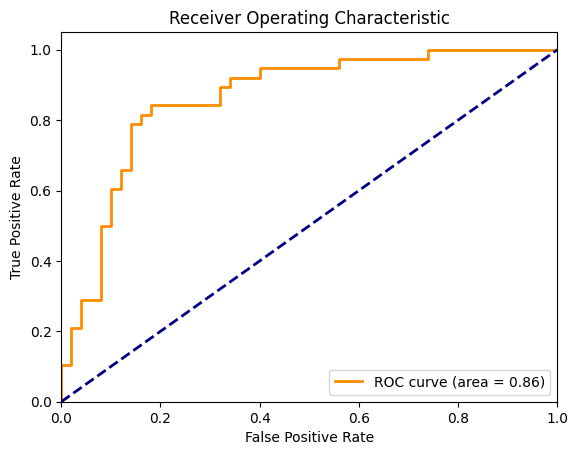

In [22]:
# Вычисляем ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:,1])

# Вычисляем AUC
auc_val = auc(fpr, tpr)

# Строим график
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)
knn_probs = knn.predict_proba(X_test_scaled)

In [24]:
print(classification_report(y_test, knn_preds))
quality_report(y_test, knn_preds)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        50
           1       0.58      0.58      0.58        38

    accuracy                           0.64        88
   macro avg       0.63      0.63      0.63        88
weighted avg       0.64      0.64      0.64        88

Accuracy: 0.636
Precision: 0.579
Recall: 0.579
f1_score: 0.579


In [25]:
knn_auc = roc_auc_score(y_test, knn_preds)
print("ROC-AUC:", knn_auc)

ROC-AUC: 0.6294736842105263


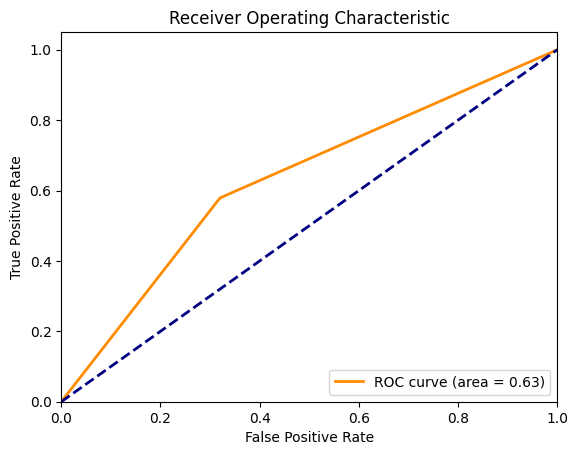

In [26]:
# Вычисляем ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:,1])

# Вычисляем AUC
auc_val = auc(fpr, tpr)

# Строим график
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

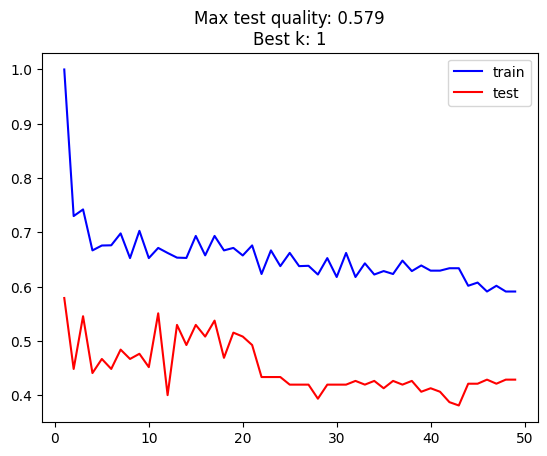

In [27]:
neighbors = range(1, 50)
f1_score_train = []
f1_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    f1_score_train.append(f1_score(knn.predict(X_train_scaled), y_train))
    f1_score_test.append(f1_score(knn.predict(X_test_scaled), y_test))
    
plt.plot(neighbors, f1_score_train, color='blue', label='train')
plt.plot(neighbors, f1_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(f1_score_test), np.argmax(f1_score_test)+1))
plt.legend();

In [28]:
from sklearn.model_selection import GridSearchCV

# параметр p отвечает за выбор метрики расстояния
param_grid = {
        'n_neighbors': range(1, 50),
        'p': range(1, 4)
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}".format(
    grid_search.best_score_, grid_search.best_estimator_.n_neighbors)
) 


test_predictions = grid_search.best_estimator_.predict(X_test_scaled)
print("Resulting test score: {:.3f}".format(f1_score(test_predictions, y_test)))

Fitting 5 folds for each of 147 candidates, totalling 735 fits
Best CV score: 0.666, best CV k: 9
Resulting test score: 0.476


In [29]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
import os
import graphviz
import pydotplus

os.environ["PATH"] += os.pathsep + '/usr/local/bin/'

def plot_tree(model, cols, fname='temp_tree.png'):
    dot_data = export_graphviz(model, filled=True, rounded=True, feature_names=cols, out_file=None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)
    # plt.axis('off')
    # plt.show()

In [30]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=5, criterion='gini')
clf.fit(X_train_scaled, y_train)
dtc_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.82      0.71      0.76        38

    accuracy                           0.81        88
   macro avg       0.81      0.80      0.80        88
weighted avg       0.81      0.81      0.80        88



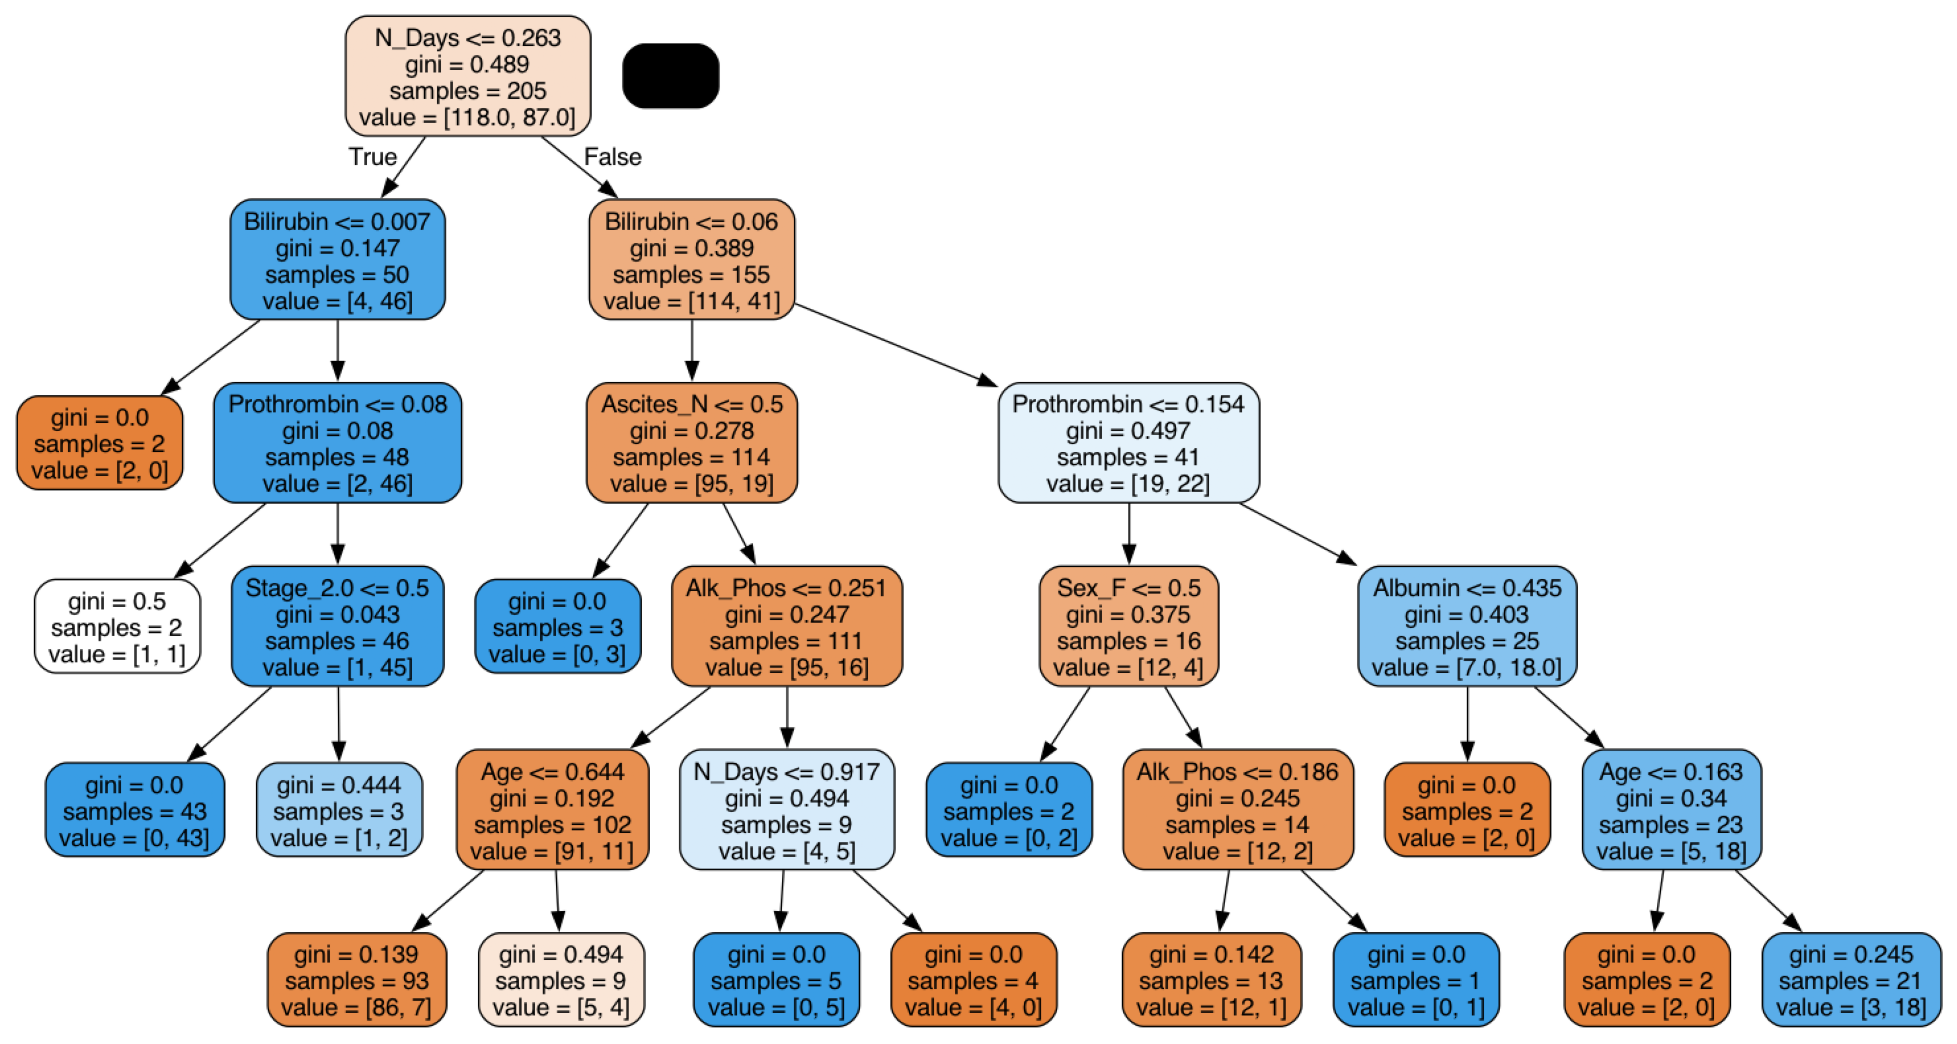

In [31]:
plt.figure(figsize=(25, 25))
plt.axis('off')
plot_tree(clf, X.columns)

In [32]:
pd.DataFrame(clf.feature_importances_, index = list(X),\
             columns = ['feature importance']).sort_values('feature importance', ascending = False)

,feature importance
N_Days,0.502850
Bilirubin,0.160389
Prothrombin,0.070627
Age,0.066991
Alk_Phos,0.066690
Ascites_N,0.058267
Sex_F,0.035013
Albumin,0.030689
Stage_2.0,0.008485
Edema_N,0.000000


In [33]:
# Import GridSearchCV class
from sklearn.model_selection import GridSearchCV

# Define Decision Tree classifier with default parameters
clf = DecisionTreeClassifier()

# Estimate grid of the classifier hyperparameters
parameters = {'max_depth':[1, 3, 5, 7, 10, None],
              'min_samples_split' : [2,5,10,20],
              'min_samples_leaf':[1, 5, 10,50]}

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='precision_macro',  # Claasification quality metric to optimize
                  cv=5)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [34]:
gs_pred = gs.predict(X_test_scaled)
quality_report(y_test,gs_pred)
print(classification_report(y_test,gs_pred))

Accuracy: 0.568
Precision: 0.000
Recall: 0.000
f1_score: 0.000
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        50
           1       0.00      0.00      0.00        38

    accuracy                           0.57        88
   macro avg       0.28      0.50      0.36        88
weighted avg       0.32      0.57      0.41        88



In [35]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier

In [36]:
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth = None, oob_score=True)
model.fit(X_train_scaled, y_train)
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(X_test_scaled), y_test):.4f}')
print(f'Train score: {accuracy_score(model.predict(X_train_scaled), y_train):.4f}')

Test score estimate using Out-of-bag score 0.8049
Actual test score: 0.7955
Train score: 1.0000


In [37]:
quality_report(y_test, model.predict(X_test_scaled))

Accuracy: 0.795
Precision: 0.812
Recall: 0.684
f1_score: 0.743


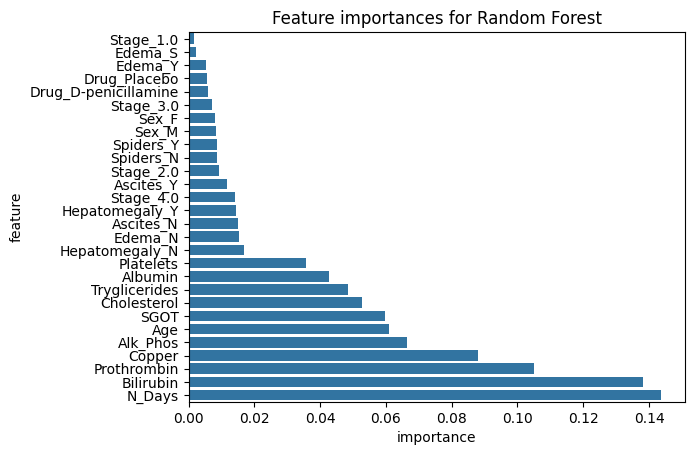

In [38]:
feature_importances = zip(X.columns, model.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1])
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

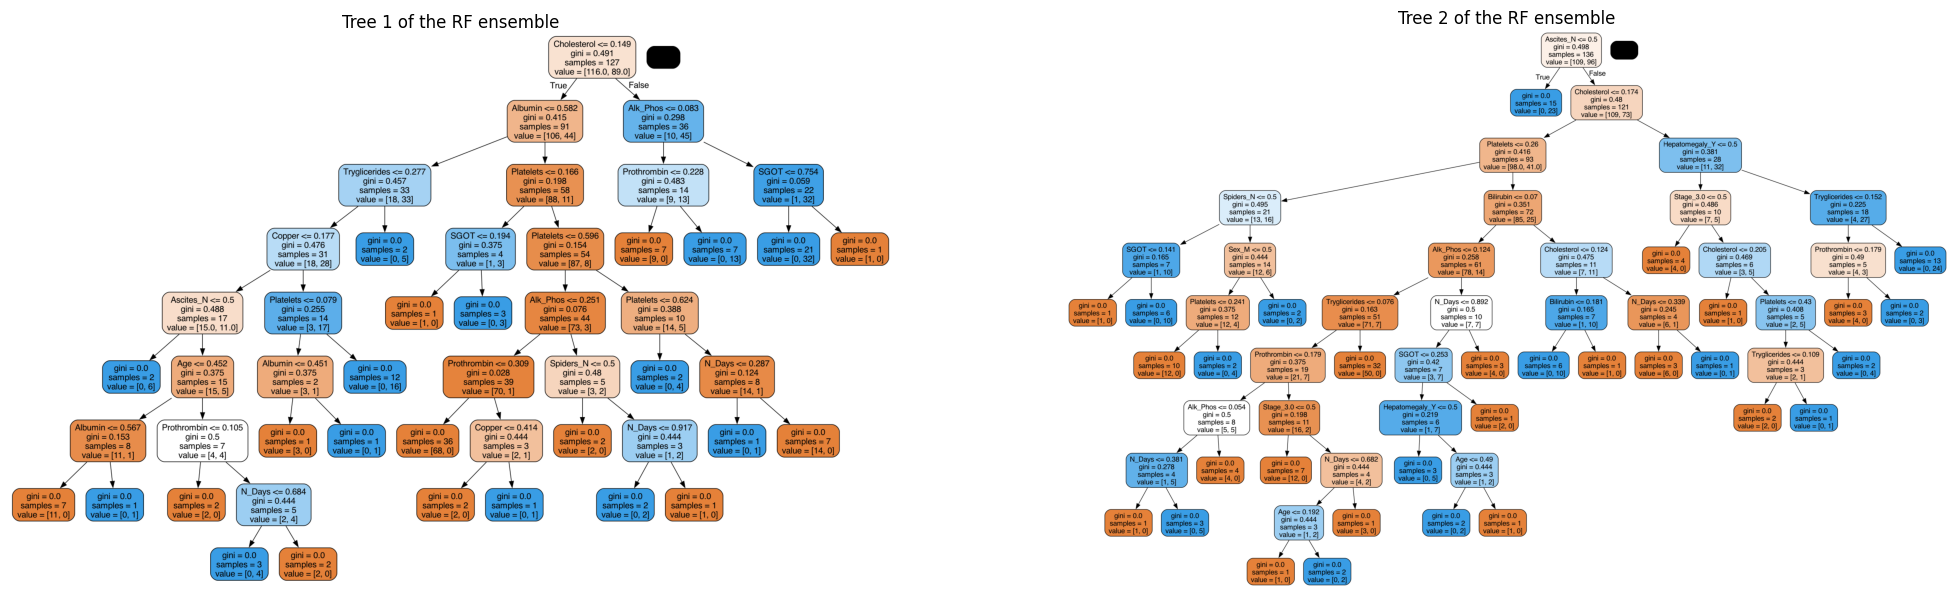

In [39]:
tree1, tree2 = model.estimators_[2], model.estimators_[3]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, X.columns)
plt.axis('off')
plt.title(f'Tree 1 of the RF ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, X.columns)
plt.axis('off')
plt.title(f'Tree 2 of the RF ensemble')
plt.show()

In [40]:
parameters = {'n_estimators': [5,10,50, 100, 500], 'max_features' : [None, 3, 5, 10], 'max_depth':[None, 3, 5, 10, 15]}

model = RandomForestClassifier()
clf = GridSearchCV(model, parameters, scoring = 'accuracy')

clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print(f'Actual test score: {accuracy_score(pred, y_test):.4f}')
print('Best parameters: ', clf.best_params_)
quality_report(y_test, pred)
print(classification_report(y_test, pred))

Actual test score: 0.8295
Best parameters:  {'max_depth': 5, 'max_features': None, 'n_estimators': 50}
Accuracy: 0.830
Precision: 0.848
Recall: 0.737
f1_score: 0.789
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.85      0.74      0.79        38

    accuracy                           0.83        88
   macro avg       0.83      0.82      0.82        88
weighted avg       0.83      0.83      0.83        88



In [41]:
model = BaggingClassifier(DecisionTreeClassifier(max_depth=3), n_jobs=-1, n_estimators=100)
model.fit(X_train_scaled, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                  n_estimators=100, n_jobs=-1)

In [42]:
print(f'Bagged trees accuracy score {accuracy_score(model.predict(X_test_scaled), y_test):.4f}')

Bagged trees accuracy score 0.7955


In [43]:
print(classification_report(y_test, model.predict(X_test_scaled)))
quality_report(y_test, model.predict(X_test_scaled))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        50
           1       0.79      0.71      0.75        38

    accuracy                           0.80        88
   macro avg       0.80      0.79      0.79        88
weighted avg       0.80      0.80      0.79        88

Accuracy: 0.795
Precision: 0.794
Recall: 0.711
f1_score: 0.750


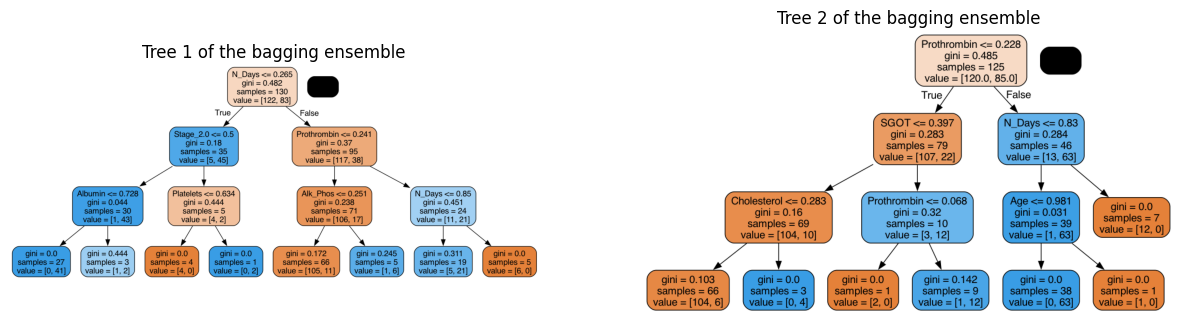

In [44]:
tree1, tree2 = model.estimators_[0], model.estimators_[1]

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, X_train.columns)
plt.axis('off')
plt.title(f'Tree 1 of the bagging ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, X_train.columns)
plt.axis('off')
plt.title(f'Tree 2 of the bagging ensemble')
plt.show()

In [45]:
model = BaggingClassifier(DecisionTreeClassifier(max_depth=None), n_jobs=-1, n_estimators=20, oob_score=True)
model.fit(X_train_scaled, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True)

In [46]:
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Test score estimate using Cross-Validation {cross_val_score(model, X_train_scaled, y_train, scoring="accuracy").mean():.4f}')
print(f'Actual test score: {accuracy_score(model.predict(X_test_scaled), y_test):.4f}')
print(f'Train score: {accuracy_score(model.predict(X_train_scaled), y_train):.4f}')

Test score estimate using Out-of-bag score 0.7659
Test score estimate using Cross-Validation 0.8000
Actual test score: 0.7955
Train score: 0.9951


In [47]:
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X_train_scaled, y_train)

est.predict(X_train_scaled)
est.predict_proba(X_train_scaled)[0]

gbc_pred = est.predict(X_test_scaled)
print('accuracy', round(accuracy_score(y_test, est.predict(X_test_scaled)),3))
print(classification_report(y_test, gbc_pred))
quality_report(y_test, est.predict(X_test_scaled))

accuracy 0.795
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        50
           1       0.76      0.76      0.76        38

    accuracy                           0.80        88
   macro avg       0.79      0.79      0.79        88
weighted avg       0.80      0.80      0.80        88

Accuracy: 0.795
Precision: 0.763
Recall: 0.763
f1_score: 0.763


In [49]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [50]:
lgbm_clf = LGBMClassifier(n_estimators=300, verbosity=-1)
lgbm_clf.fit(X_train_scaled, y_train)
lgbm_pred = lgbm_clf.predict(X_test_scaled)

In [51]:
print(classification_report(y_test, lgbm_pred))
quality_report(y_test, lgbm_pred)

              precision    recall  f1-score   support

           0       0.77      0.82      0.80        50
           1       0.74      0.68      0.71        38

    accuracy                           0.76        88
   macro avg       0.76      0.75      0.75        88
weighted avg       0.76      0.76      0.76        88

Accuracy: 0.761
Precision: 0.743
Recall: 0.684
f1_score: 0.712


In [52]:
print(roc_auc_score(y_test, lgbm_clf.predict(X_test_scaled)))

0.7521052631578947


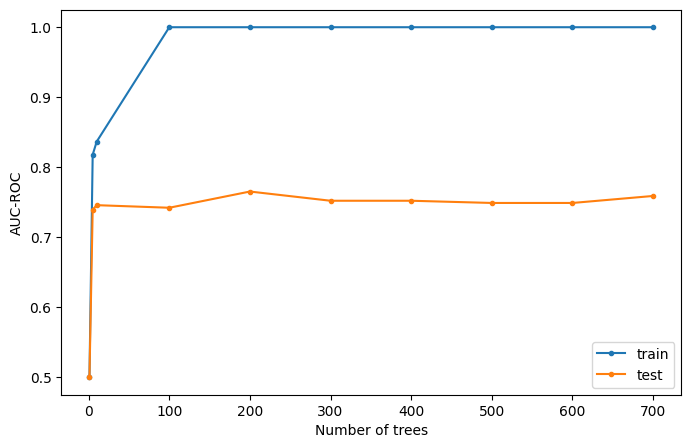

In [53]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n, verbosity=-1)
    clf.fit(X_train_scaled, y_train)
    q_train = roc_auc_score(y_train, clf.predict(X_train_scaled))
    q_test = roc_auc_score(y_test, clf.predict(X_test_scaled))
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

In [54]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train_scaled, y_train)
cb_pred = clf.predict(X_test_scaled)


print('ROC-AUC score:',roc_auc_score(y_test, clf.predict(X_test_scaled)))
print(classification_report(y_test, cb_pred))
quality_report(y_test, clf.predict(X_test_scaled))

ROC-AUC score: 0.7984210526315789
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.80      0.74      0.77        38

    accuracy                           0.81        88
   macro avg       0.81      0.80      0.80        88
weighted avg       0.81      0.81      0.81        88

Accuracy: 0.807
Precision: 0.800
Recall: 0.737
f1_score: 0.767


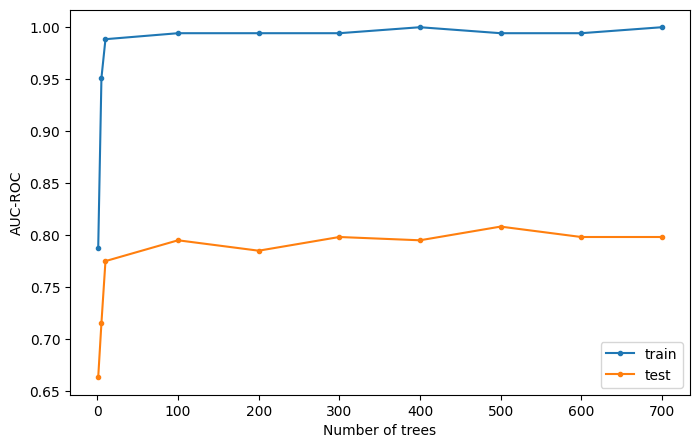

In [55]:
from catboost import CatBoostClassifier
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train_scaled, y_train)
    q_train = roc_auc_score(y_train, clf.predict(X_train_scaled))
    q_test = roc_auc_score(y_test, clf.predict(X_test_scaled))
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

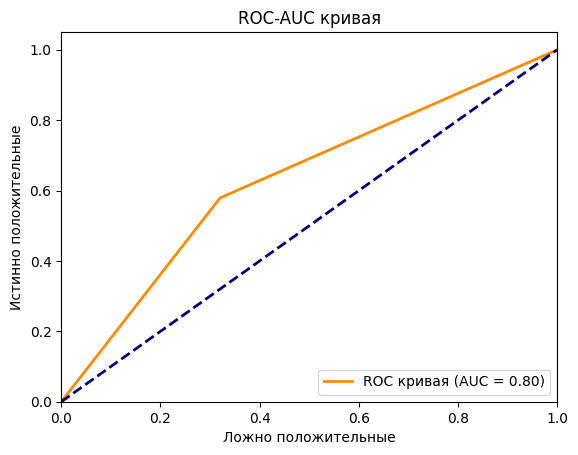

In [62]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая (AUC = %0.2f)' % roc_auc_score(y_test, clf.predict(X_test_scaled)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложно положительные')
plt.ylabel('Истинно положительные')
plt.title('ROC-AUC кривая')
plt.legend(loc="lower right")
plt.show()

In [57]:
from xgboost import XGBClassifier

In [58]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scaled, y_train)
xgb_pred = xgb_clf.predict(X_test_scaled)

In [59]:
xgb_auc = roc_auc_score(y_test, xgb_clf.predict(X_test_scaled))
print(xgb_auc)

0.7984210526315789


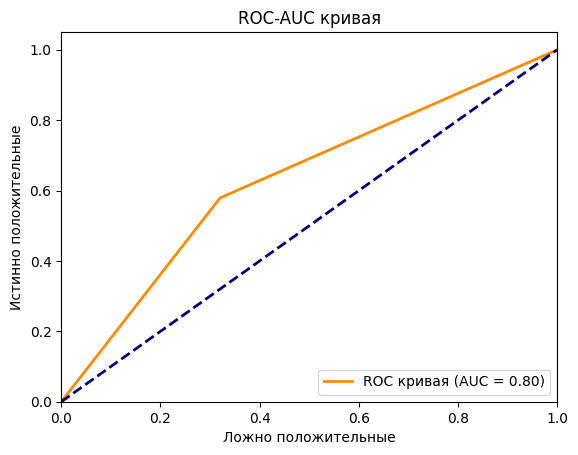

In [60]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая (AUC = %0.2f)' % xgb_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложно положительные')
plt.ylabel('Истинно положительные')
plt.title('ROC-AUC кривая')
plt.legend(loc="lower right")
plt.show()

In [61]:
print(classification_report(y_test, xgb_pred))
quality_report(y_test, xgb_pred)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.80      0.74      0.77        38

    accuracy                           0.81        88
   macro avg       0.81      0.80      0.80        88
weighted avg       0.81      0.81      0.81        88

Accuracy: 0.807
Precision: 0.800
Recall: 0.737
f1_score: 0.767
